In [1]:
import sys
sys.path.insert(0, "../../")

In [2]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

Using TensorFlow backend.


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

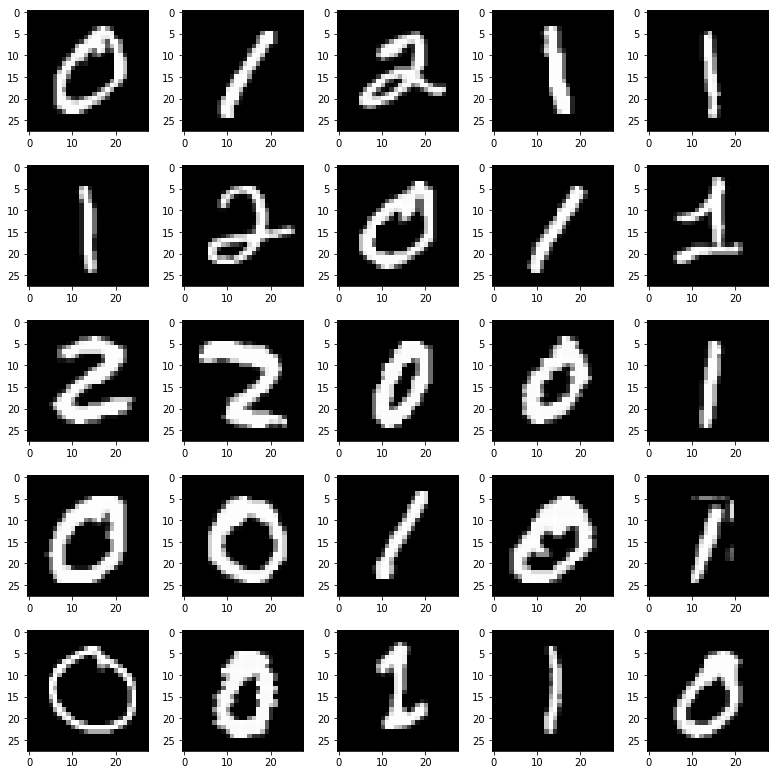

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

### Model definition

The implementation for the generative model for a NLPCA model (Algorithm 3) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [19]:
# Model constants
k, d0, d1 = 2, 100, np.shape(x_train)[-1]

# initial values
loc_init = 0.001
scale_init = 1

@inf.probmodel
def nlpca(k, d0, d1, decoder):

    with inf.datamodel():
        # Define local latent variables
        z = inf.Normal(loc=tf.ones([k]), scale=1, name="z")

        output = decoder(k, d0, d1, z)

        # Define the observed variables
        x = inf.Normal(loc=output, scale=1., name="x")


def decoder(k, d0, d1, z):
    return Sequential([
        Dense(d0, input_shape=(k,)),
        Dense(d1, activation="relu"),
    ])(tf.convert_to_tensor(z))

print(nlpca)
print(decoder)

<function nlpca at 0x137637d08>
<function decoder at 0x13151c7b8>


This is a latent varable model (LVM) containing DNNs where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using a DNN parametrized by $\boldsymbol{\beta}$ and $\boldsymbol{\alpha}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [20]:
@inf.probmodel
def Q(k, d0, d1):

    with inf.datamodel():
        qz_loc = inf.Parameter(tf.ones([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

print(Q)

<function Q at 0x137637bf8>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\beta, \alpha})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In InferPy, this is transparent to the user: it is only required to create the instances of the P and Q models, the optimizer and inference method objects.

In [21]:
# create an instance of the P model and the Q model
m = nlpca(k, d0, d1, decoder)
q = Q(k,d0,d1)

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=2000)

Finally, the ELBO function is maximized.

In [22]:
m.fit({"x": x_train}, VI)        


 0 epochs	 2896143104.0....................
 200 epochs	 1636803968.0....................
 400 epochs	 1374125312.0....................
 600 epochs	 1319423616.0....................
 800 epochs	 1178726016.0....................
 1000 epochs	 1145951232.0....................
 1200 epochs	 1132628224.0....................
 1400 epochs	 1125415936.0....................
 1600 epochs	 1120012416.0....................
 1800 epochs	 1116219776.0....................

After the inference, we can plot the hidden representation:

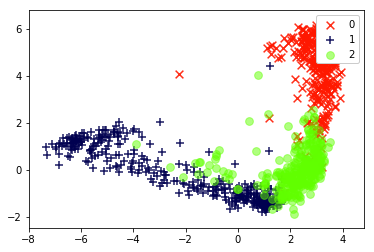

In [23]:
post = {"z": m.posterior("z", data={"x": x_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend(loc='upper right',framealpha=1)

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

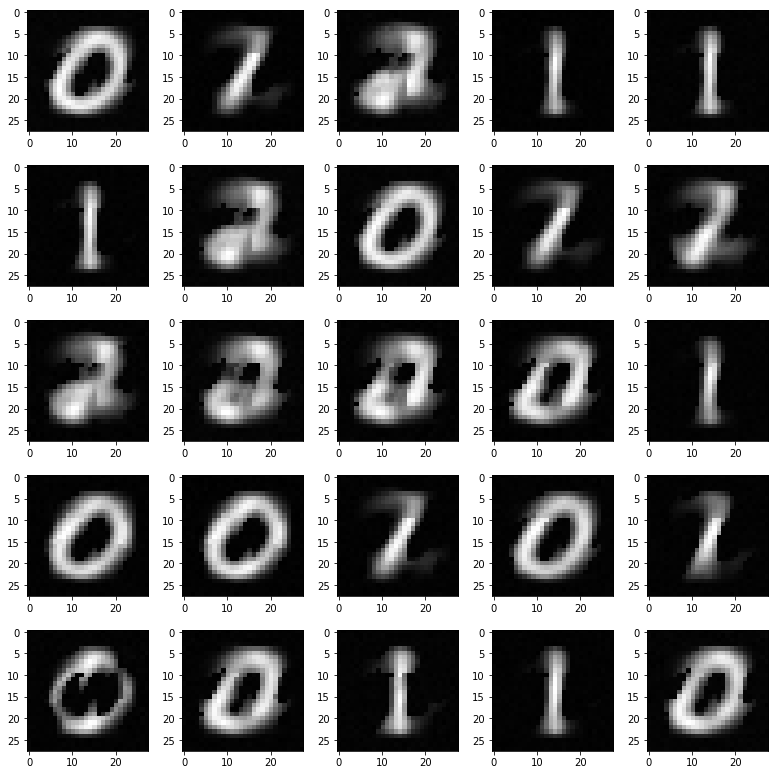

In [9]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])